Part 2: Create a stitched panorama from multiple overlapping images

In [1]:
#importing requirements
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Function to detect Feature (Keypoint and descriptors)
def detect_features(image):
    """Detects keypoints and descriptors using SIFT"""
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

In [4]:
#Function to stitch image
def stitch_images(base_img, new_img, base_kp, base_des, new_kp, new_des, direction="right"):
    """Stitches two images using KNN-based feature matching and homography"""

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    # top 2 nearest matches
    matches = bf.knnMatch(new_des, base_des, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:  # 0.7 - threshold
            good_matches.append(m)

    if len(good_matches) > 4:
        # matching keypoints
        src_pts = np.float32([new_kp[m.queryIdx].pt for m in good_matches]).reshape(
            -1, 1, 2
        )
        dst_pts = np.float32([base_kp[m.trainIdx].pt for m in good_matches]).reshape(
            -1, 1, 2
        )

        # homography matrix
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # output size
        height_base, width_base = base_img.shape[:2]
        height_new, width_new = new_img.shape[:2]

        # corners of the new image after transformation
        corners_new = np.float32(
            [[0, 0], [0, height_new], [width_new, height_new], [width_new, 0]]
        ).reshape(-1, 1, 2)
        warped_corners = cv2.perspectiveTransform(corners_new, H)

        # bounding box of the stitched result
        all_corners = np.vstack(
            (
                warped_corners,
                np.array(
                    [
                        [0, 0],
                        [0, height_base],
                        [width_base, height_base],
                        [width_base, 0],
                    ]
                ).reshape(-1, 1, 2),
            )
        )
        [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel())
        [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel())

        # adjust for negative coordinates
        translation_mat = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])

        # output size
        output_width = x_max - x_min
        output_height = y_max - y_min
        warped_img = cv2.warpPerspective(
            new_img, translation_mat @ H, (output_width, output_height)
        )

        # overlay base image correctly
        stitched = warped_img.copy()
        stitched[-y_min : height_base - y_min, -x_min : width_base - x_min] = base_img

        return stitched
    else:
        print(f"Not enough matches found for {direction} stitcher!")
        return base_img

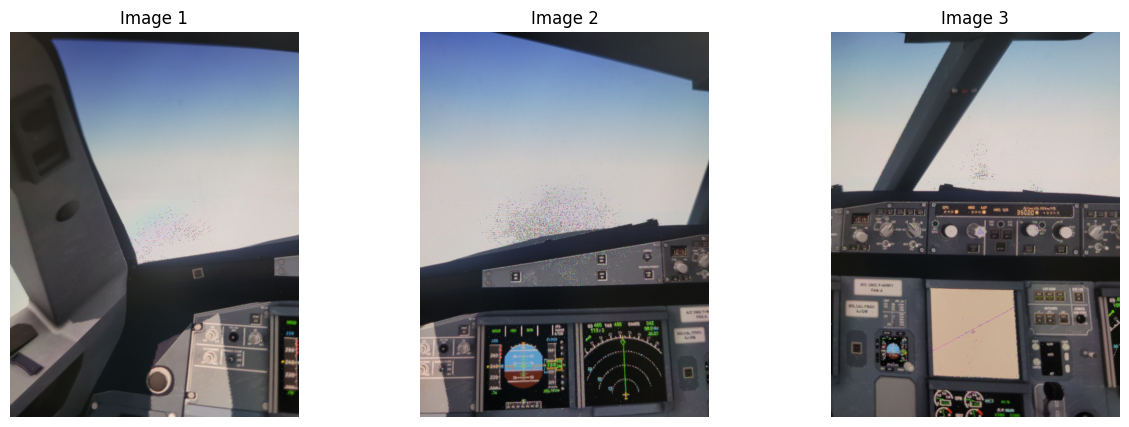

Loading Panorama


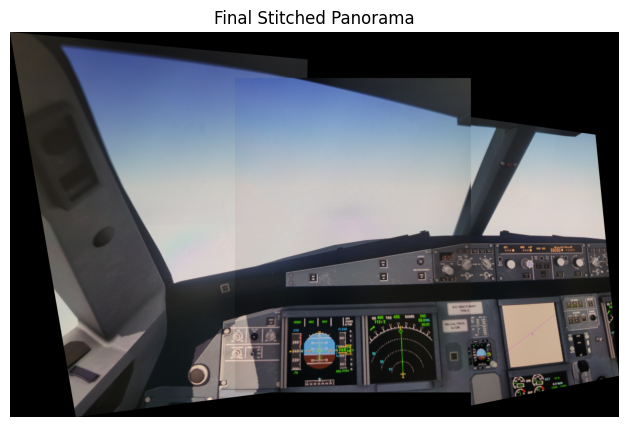

In [7]:
image_files = ["./images/Image_1.jpeg", "./images/Image_2.jpeg", "./images/Image_3.jpeg"]
images = [cv2.imread(img) for img in image_files]

gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

keypoints_descriptors = [detect_features(img) for img in gray_images]

fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

for i, (kp_des, img) in enumerate(zip(keypoints_descriptors, images)):
    kp, des = kp_des
    img_with_keypoints = cv2.drawKeypoints(img, kp, None)

    axes[i].imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis("off")
plt.show()

print("Loading Panorama")

base_img = images[1]
base_kp, base_des = keypoints_descriptors[1]

# Left Stitcher: Stitch first image (left side)
left_stitched = stitch_images(
    images[1],
    images[0],
    base_kp,
    base_des,
    keypoints_descriptors[0][0],
    keypoints_descriptors[0][1],
    direction="left",
)

# updating keypoints and descriptors for left-stitched image**
left_kp, left_des = detect_features(left_stitched)

# Right Stitcher: Stitch third image (right side) using updated keypoints
final_stitched = stitch_images(
    left_stitched,
    images[2],
    left_kp,
    left_des,
    keypoints_descriptors[2][0],
    keypoints_descriptors[2][1],
    direction="right",
)

# Display final stitched panorama
plt.figure(figsize=(15, 5))
plt.imshow(cv2.cvtColor(final_stitched, cv2.COLOR_BGR2RGB))
plt.title("Final Stitched Panorama")
plt.axis("off")
plt.show()